**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_1_1_)    
      - [Importing Python Libraries](#toc1_1_1_1_)    
      - [Loading Clean Dataset](#toc1_1_1_2_)    
    - [Trying Word Embeddings for Store names](#toc1_1_2_)    
    - [Logistic Regression](#toc1_1_3_)    
      - [Hyper parameter tuning](#toc1_1_3_1_)    
      - [Model Evaluation](#toc1_1_3_2_)    
      - [Model Coefficients](#toc1_1_3_3_)    
      - [Analyzing False Positives & False Negatives from Logistic Regression](#toc1_1_3_4_)    
    - [Logistic Regression with Downsampling](#toc1_1_4_)    
    - [Random Forest](#toc1_1_5_)    
      - [Hyperparameter tuning](#toc1_1_5_1_)    
    - [Random Forest with downsampling](#toc1_1_6_)    
    - [Naive Bayes Classifier](#toc1_1_7_)    
    - [Extra Checks](#toc1_1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Introduction](#toc0_)

In this notebook, we will train two baseline models on our preprocessed data.
 - Logistic Regression  
 - Random Forest

Additionally, we will evaluate and compare model performance. To improve accuracy, we will also explore downsampling as a technique for handling class imbalances.  

#### <a id='toc1_1_1_1_'></a>[Importing Python Libraries](#toc0_)

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS,TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
import string
import spacy

# Ignore all warnings to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

In [57]:
#Useful settings

plt.rcParams['figure.figsize'] = (8.0, 6.0) # set matplotlib global settings eg. figsize
# plt.rcParams['font.size']=17              # useful when saving figures
sns.set_style("darkgrid")                   #Setting grid style in seaborn

# Uncomment if necessary
#pd.set_option('display.max_columns', None) # show all dataframe columns
#pd.set_option('display.max_colwidth', 1000)  # display long column titles

# from warnings import filterwarnings
# filterwarnings(action='ignore')

#### <a id='toc1_1_1_2_'></a>[Loading Clean Dataset](#toc0_)

In [58]:
# Here we load the preprocessed DataFrame that contains the necessary columns for modeling
model_df = pd.read_pickle('../data/meta_review_sample_preprocessed.pkl')
model_df.head()

,product_price,highly_rated_product,product_title_length,store_grouped_total_products,average_rating,num_product_images,store_grouped_weighted_mean_rating,store_grouped_std_rating,has_package_density,package_density,...,review_text_word_counts_store_grouped,verified_purchase_ratio_store_grouped,weighted_helpfulness_store_grouped,one_to_five_star_store_grouped,num_reviews_combined_category_grouped,avg_user_rating_combined_category_grouped,std_user_rating_combined_category_grouped,review_title_word_counts_combined_category_grouped,review_text_word_counts_combined_category_grouped,one_to_five_star_combined_category_grouped
0,24.00,0,33,52,4.4,3,4.482692,0.380259,1,0.074682,...,23.365044,0.980477,0.772124,0.051213,20154,4.372829,1.243143,3.288975,22.939615,0.105545
1,12.95,0,143,868,4.5,8,4.399885,0.383498,1,0.162845,...,18.927813,0.961375,0.081823,0.138847,41110,4.548090,1.094330,3.300122,21.584164,0.072742
2,31.00,0,172,44,4.4,8,4.656818,0.325217,0,0.105715,...,21.185315,0.888199,0.230769,0.019084,10528,4.646657,0.956326,3.435695,24.045118,0.046040
3,3.99,0,169,11323,4.1,2,4.496573,0.568533,0,0.041667,...,24.487361,0.970938,0.366214,0.073569,1040,4.501923,1.146613,3.480769,23.256731,0.082536
4,15.59,1,181,12,4.6,8,4.591667,0.317543,0,0.019231,...,23.785714,0.982456,0.250000,0.021277,3953,4.431318,1.188636,3.405009,24.865166,0.088787


In [59]:
#Set parent_asin column as the index of dataframe
model_df.set_index('parent_asin', inplace=True)

In [60]:
#check if there are any missing values
model_df.isna().sum().loc[lambda x: x> 0]

Series([], dtype: int64)

### <a id='toc1_1_2_'></a>[Trying Word Embeddings for Store names](#toc0_)

In [61]:
# Let's download en_core_web_sm trained model
#!python -m spacy download en_core_web_lg -q

# Load the pre-trained spaCy model
# nlp = spacy.load("en_core_web_lg")

In [62]:
# # Function to get embeddings for a store name - spacy treats evey store name as an individual word
# def get_embedding_store(word, model):
#     doc = model(word)  # Process the word with spaCy
#     return doc.vector  # Return the word vector

# # Generate embeddings for each store
# embedding_size = nlp.vocab.vectors_length  # Get the size of the embedding vectors
# cat_embeddings = {store: get_embedding_store(store, nlp) for store in model_df['store_grouped'].unique()}

# # Add embeddings to DataFrame
# for i in range(embedding_size):
#     model_df[f'cat_embedding_{i}'] = model_df['store_grouped'].apply(lambda x: cat_embeddings[x][i])

# # Drop the original column
# model_df.drop(columns=['store_grouped'], inplace=True)

# model_df.head()

In [63]:
# # Function to get embeddings for a text (e.g., product title or description)
# def get_embedding(text, model):
#     doc = model(text)  # Process the text with spaCy
#     word_vectors = [token.vector for token in doc if token.has_vector]  # Get vectors for all words
#     if word_vectors:  # If at least one word has a vector
#         return np.mean(word_vectors, axis=0)  # Return the average of word vectors
#     else:
#         return np.zeros(model.vocab.vectors_length)  # Return zero vector if no words have vectors
    

# # Generate embeddings for product titles
# embedding_size = nlp.vocab.vectors_length  # Get the size of the embedding vectors
# for i in range(embedding_size):
#     model_df[f'title_embedding_{i}'] = model_df['product_title'].apply(lambda x: get_embedding(x, nlp)[i])

# Generate embeddings for product descriptions
# df['description_embedding'] = df['product_description'].apply(lambda x: get_embedding(x, nlp))

### <a id='toc1_1_3_'></a>[Logistic Regression](#toc0_)

In this section, we will train a logistic regression model using a pipeline. Our pipeline will consist of:

- One Hot encoder for store column/sub_category columns
- TfIDF Vectorizer for product features or other text based columns
- Standard Scaler
- Logistic Regression

In [64]:
#lets prepare data for modeling

#Define features
X = model_df.drop(columns=['highly_rated_product','average_rating'])

#define target
y=model_df['highly_rated_product']
X.columns

Index(['product_price', 'product_title_length', 'store_grouped_total_products',
       'num_product_images', 'store_grouped_weighted_mean_rating',
       'store_grouped_std_rating', 'has_package_density', 'package_density',
       'product_age_days', 'store_grouped', 'subcategory1_total_products',
       'subcategory1_mean_rating', 'subcategory1_std_rating',
       'subcategory1_std_rating_number',
       'combined_category_weighted_mean_rating',
       'combined_category_total_products',
       'combined_category_mean_rating_number',
       'combined_category_std_rating_number', 'spacy_tokenized_features',
       'combined_category', 'num_reviews_store_grouped',
       'avg_user_rating_store_grouped', 'std_user_rating_store_grouped',
       'review_title_word_counts_store_grouped',
       'review_text_word_counts_store_grouped',
       'verified_purchase_ratio_store_grouped',
       'weighted_helpfulness_store_grouped', 'one_to_five_star_store_grouped',
       'num_reviews_combined_ca

In [65]:
#lets split the data into train and test before applying transformations

X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, stratify = y,random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.3, stratify = y_remainder,random_state = 2)

print(X.shape)

(38127, 34)


In [66]:
X.columns
X.isna().sum().loc[lambda x: x> 0]
#X_train.head()
X.shape

(38127, 34)

In [67]:
# # Step 2: Define the get_embedding Function
# def get_embedding(text, model):
#     """
#     Generate an embedding for a text by averaging the word vectors of all words in the text.
#     """
#     doc = model(text)  # Process the text with spaCy
#     word_vectors = [token.vector for token in doc if token.has_vector]  # Get vectors for all words
#     if word_vectors:  # If at least one word has a vector
#         return np.mean(word_vectors, axis=0)  # Return the average of word vectors
#     else:
#         return np.zeros(model.vocab.vectors_length)  # Return zero vector if no words have vectors

# # Step 3: Define the Custom Transformer
# class TextEmbedder(BaseEstimator, TransformerMixin):
#     """
#     Custom transformer to generate embeddings for a text column.
#     """
#     def __init__(self, text_column, model):
#         self.text_column = text_column  # Name of the text column (e.g., 'product_title')
#         self.model = model  # Pre-trained model (e.g., spaCy's `nlp`)

#     def fit(self, X, y=None):
#         # No fitting required since we're using a pre-trained model
#         return self

#     def transform(self, X):
#         """
#         Generate embeddings for each text in the specified column.
#         """
#         embeddings = X[self.text_column].apply(lambda x: get_embedding(x, self.model))
#         return np.vstack(embeddings)  # Convert list of arrays to a 2D array

In [ ]:
#Build a pipeline to systematically apply all the transformations to the training data

#Instantiate TF-IDF Vectorizer to transform text based columns
tfidf_features = TfidfVectorizer(token_pattern=r"\b[a-z]{3,}\b",  #tokens should only consider 3 or more letters
                                lowercase=True,
                                min_df=10,                 # consider tokens that appear in atleast 5% of documents
                                max_df=0.9,                  # remove words that appear in more than 90% of documents
                                stop_words='english',        # exclude stop words
                                max_features=3000)        

tfidf_review = TfidfVectorizer(token_pattern=r"\b[a-z]{3,}\b",  #tokens should only consider 3 or more letters
                                lowercase=True,
                                min_df=0.05,                 # consider tokens that appear in atleast 5% of documents
                                max_df=0.9,                  # remove words that appear in more than 90% of documents
                                stop_words='english',        # exclude stop words
                                max_features=3000)             

#Define Column Transformer to apply Count Vectorizer to Specific columns in the dataset 
col_transforms = [
     ("features_transform", tfidf_features, "spacy_tokenized_features"),
    ("ohe", OneHotEncoder( handle_unknown="ignore"), ["store_grouped","combined_category"])
]

# Create the column transformer
preprocessor = ColumnTransformer(col_transforms,remainder='passthrough')

#Define steps for a pipeline
steps = [
("preprocessor", preprocessor),
("normalize", StandardScaler(with_mean=False)),
#('embedder', TextEmbedder(text_column='combined_category', model=nlp)),  # Generate embeddings
("logreg", LogisticRegression()),
]

#Instantiate Pipeline
pipe_logreg = Pipeline(steps)

#Fit Pipeline
pipe_logreg.fit(X_train,y_train)

#Cross Validation Accuracy
avg_cv_score = np.mean(cross_val_score(pipe_logreg, X_train,y_train,cv=5))


#Score
print(f' Train Accuracy: {np.round(pipe_logreg.score(X_train,y_train),4)}')
print(f' Validation Accuracy: {np.round(pipe_logreg.score(X_val,y_val),4)}')



 Train Accuracy: 0.7461
 Validation Accuracy: 0.6168


#### <a id='toc1_1_3_1_'></a>[Hyper parameter tuning](#toc0_)

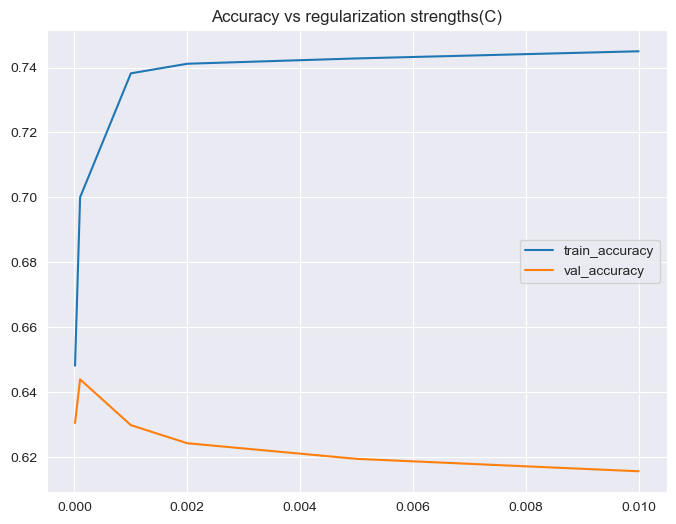

In [69]:
# Tune regularization in Logistic Regression 

train_accuracy = []
val_accuracy = []
param_range = [1e-5, 1e-4, 0.001, 0.002, 0.005, 0.01]

#Instantiate pipeline
pipe_loop = Pipeline([
    ("preprocessor", preprocessor),
    ("normalize", StandardScaler(with_mean=False)),
    ("log_reg", LogisticRegression())  # Default parameters
])


for C_param in param_range:
        
    #Update parameter hyper-parameter for every iteration
    pipe_loop.set_params(log_reg__C = C_param)    

    #Fit data
    pipe_loop.fit(X_train, y_train)

    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(param_range,train_accuracy,label='train_accuracy')
plt.plot(param_range,val_accuracy,label='val_accuracy')
plt.title('Accuracy vs regularization strengths(C)')
plt.legend()
plt.show()

We observe minimal overfitting with high regularization strength. Therefore we will retrain our model using C=1e-4.

In [70]:
#Refitting Logreg with C=1e-4

steps = [
("preprocessor", preprocessor),
("normalize", StandardScaler(with_mean=False)),
("logreg", LogisticRegression(C=1e-4)),
]

#Instantiate Pipeline
pipe_logreg_final = Pipeline(steps)

#Fit Pipeline
pipe_logreg_final.fit(X_train,y_train)
avg_cv_score = np.mean(cross_val_score(pipe_logreg, X_train,y_train,cv=5))


#Score
print(f' Train Accuracy of final model: {np.round(pipe_logreg_final.score(X_train,y_train),4)}')
print(f' Test Accuracy of final model: {np.round(pipe_logreg_final.score(X_test,y_test),4)}')


 Train Accuracy of final model: 0.7
 Test Accuracy of final model: 0.6383


#### <a id='toc1_1_3_2_'></a>[Model Evaluation](#toc0_)

Confusion matrices: 



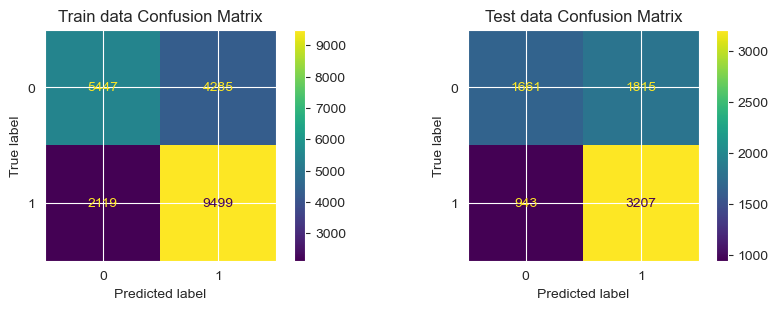


Train data classification report: 
               precision    recall  f1-score   support

           0       0.72      0.56      0.63      9732
           1       0.69      0.82      0.75     11618

    accuracy                           0.70     21350
   macro avg       0.70      0.69      0.69     21350
weighted avg       0.70      0.70      0.69     21350


Test data classification report: 
               precision    recall  f1-score   support

           0       0.64      0.48      0.55      3476
           1       0.64      0.77      0.70      4150

    accuracy                           0.64      7626
   macro avg       0.64      0.63      0.62      7626
weighted avg       0.64      0.64      0.63      7626



In [71]:
#Make predictions
y_pred_train = pipe_logreg_final.predict(X_train)
y_pred_test = pipe_logreg_final.predict(X_test)

print_line = "\n=======================================================\n"
# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
ConfusionMatrixDisplay.from_estimator(pipe_logreg_final, X_train, y_train, ax=axes[0])
axes[0].set_title("Train data Confusion Matrix")

# Model on the upsampled data
ConfusionMatrixDisplay.from_estimator(pipe_logreg_final, X_test, y_test, ax=axes[1])
axes[1].set_title("Test data Confusion Matrix")

plt.show()

# also saving the confusion matrix
conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_pred_test),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)

# Classification Reports
print("\nTrain data classification report:", print_line, classification_report(y_train,y_pred_train))
print("\nTest data classification report:", print_line, classification_report(y_test,y_pred_test))

**Key Insights**

**Accuracy Consistency**: The accuracy is slightly different across the training and test datasets (~71% and ~64%, respectively), indicating moderate overfitting. However, the overall performance suggests that the model may not be capturing complex patterns effectively.

**Precision**: For the positive class (Reviewer_Score = 1), the precision on training data is 0.69, while on test data, it is 0.64. This indicates that the model is reasonably good at identifying positive reviews, but there is a slight decrease in precision on the test set, suggesting some reduction in confidence when generalizing to unseen data.

**Recall**: The recall for the positive class is 0.82 on the training data, which drops to 0.77 on the test data. While still strong, this drop in recall on the test data suggests that the model might be missing slightly more positive reviews when it is tested on unseen data compared to when it was trained. However, the recall for the negative class (Reviewer_Score = 0) is relatively low on both the training and test data. This indicates that the **model is missing many of the low-rated items**. 

**F1 score**: The F1-score for the positive class is 0.75 on the training data, and 0.70 on the test data. This decrease in F1 score on the test set reflects the combined effects of the drop in both precision and recall when moving from training to test data.

**Performance across classes**: The model performs better for the positive class (Reviewer_Score = 1), with higher precision and recall compared to the negative class (Reviewer_Score = 0). For the negative class, both precision and recall are lower, which is expected due to an imbalance in the target variable. The model’s inability to identify many of the low-rated items is a concern for improving overall performance.

Next, we will compute ROC-AUC scores for the Logistic Regression model to further evaluate its performance and assess its ability to distinguish between high and low-rated items across various thresholds.

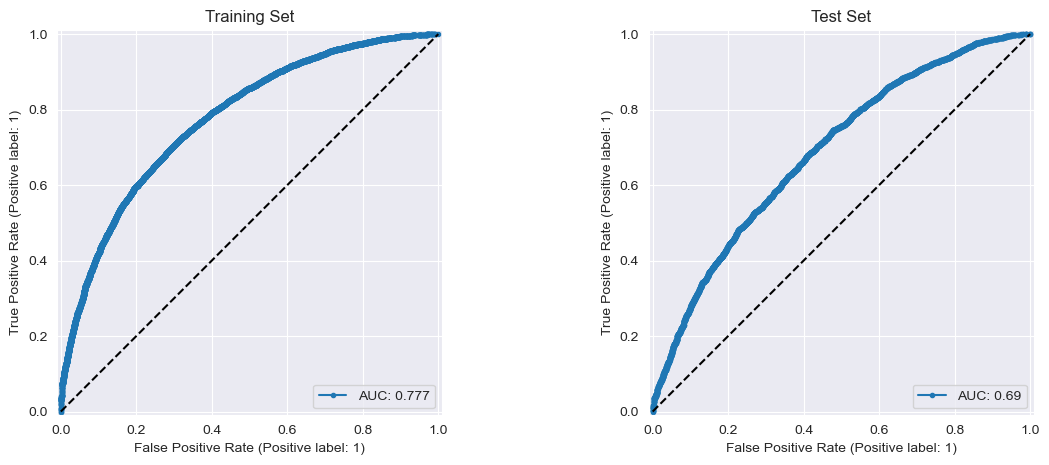

In [72]:
#Compute ROC-AUC curve for positive class

# Set up subplot structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predict probabilities
y_proba_train = pipe_logreg_final.predict_proba(X_train)[:, 1]
y_proba_test = pipe_logreg_final.predict_proba(X_test)[:, 1]

# Score (AUC)
auc_train = np.round(roc_auc_score(y_train, y_proba_train), 3)
auc_test = np.round(roc_auc_score(y_test, y_proba_test), 3)

# Labels
train_label = f"AUC: {auc_train}"
test_label = f"AUC: {auc_test}"

# Plot ROC curve

# Using RocCurveDisplay - pass in the fitted model, then the X data, then the y data
RocCurveDisplay.from_estimator(pipe_logreg_final, X_train, y_train, ax=axes[0], marker=".", label=train_label)
RocCurveDisplay.from_estimator(pipe_logreg_final, X_test, y_test, ax=axes[1], marker=".", label=test_label)

axes[0].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[1].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[0].set_title("Training Set")
axes[1].set_title("Test Set")

plt.show()

**ROC-AUC Score**: A ROC-AUC score of 0.69 indicates that the model might not perform well in distinguishing between positive and negative reviews. In other words, there is only a 69% chance that the model ranks a randomly chosen positive review higher than a randomly chosen negative review. This suggests that the model’s ability to discriminate between the two classes is relatively weak.

**Training vs. Validation ROC-AUC**: The large discrepancy in the ROC-AUC scores between the training and validation datasets suggests that the model fails to generalize well to unseen data. This indicates potential overfitting, where the model performs well on the training set but struggles with new, unseen data.


**Overall Conclusion : Potential Underfitting**

The overall performance suggests that the model may be underfitting the data. The relatively low recall for the negative class, along with the moderate precision and F1 scores, indicates that the model is not capturing enough complexity in the data. Additionally, the low ROC-AUC score further reinforces this, showing that the model struggles to distinguish between high- and low-rated products.

#### <a id='toc1_1_3_3_'></a>[Model Coefficients](#toc0_)

In this section, we analyze which features are considered most important by the model in predicting whether an item is highly rated or not.

In [73]:
# Put the variable names and their coefficient values into a data frame

#Get feature names from the ColumnTransformer
feature_names = pipe_logreg_final.named_steps['preprocessor'].get_feature_names_out()
#feature_names = X_train.columns

#Extract coefficients from the logistic regression model
coefficients = pipe_logreg_final.named_steps['logreg'].coef_[0]  

# Create the DataFrame to map feature names to coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

#Sort by absolute value of coefficients
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True, ignore_index=True)

coef_df_top20 = coef_df.head(20)  #display top 20 coefficients
coef_df_top20                    

,Feature,Coefficient,Abs_Coefficient
0,remainder__store_grouped_weighted_mean_rating,0.070339,0.070339
1,remainder__std_user_rating_store_grouped,-0.059855,0.059855
2,remainder__avg_user_rating_store_grouped,0.049091,0.049091
3,remainder__one_to_five_star_store_grouped,-0.036597,0.036597
4,remainder__store_grouped_std_rating,-0.027910,0.027910
5,remainder__std_user_rating_combined_category_g...,-0.027384,0.027384
6,remainder__product_price,0.025487,0.025487
7,remainder__has_package_density,-0.024745,0.024745
8,remainder__review_title_word_counts_combined_c...,-0.024317,0.024317
9,remainder__subcategory1_std_rating,-0.022162,0.022162


In [74]:
coef_df.shape

(4071, 3)

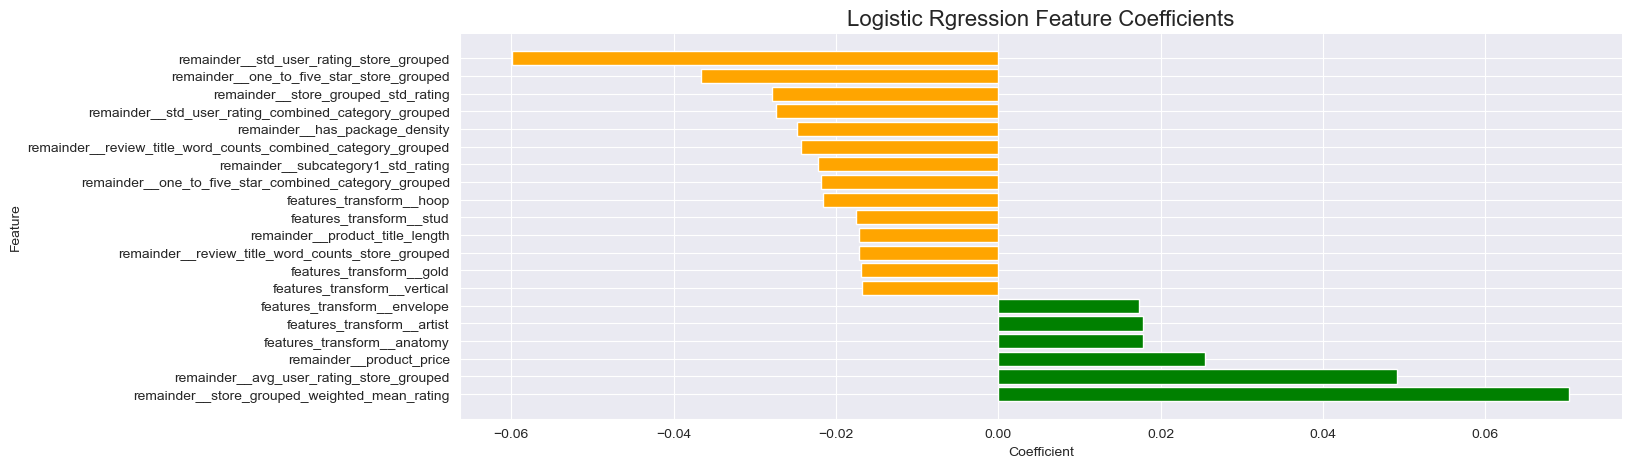

In [75]:
# Plotting Coefficients 
plt.figure(figsize=(15,5))

positive_coefs = coef_df_top20[coef_df_top20['Coefficient'] >=0]
negative_coefs = coef_df_top20[coef_df_top20['Coefficient'] < 0]

# Sort positive and negative coefficients in descending order
positive_coefs = positive_coefs.sort_values(by='Coefficient', ascending=False)
negative_coefs = negative_coefs.sort_values(by='Coefficient', ascending=False) 

plt.barh(positive_coefs['Feature'], positive_coefs['Coefficient'],color='green')
plt.barh(negative_coefs['Feature'], negative_coefs['Coefficient'],color='orange')

plt.title('Logistic Rgression Feature Coefficients', fontsize=16)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
sns.despine()
plt.show()

**Key Insights**

- The model primarily relies on numerical features, such as the store’s mean rating, the percentage of low-rated items in a store, the mean rating of the sub-category the product belongs to, and the product’s price, as the most important factors in predicting high vs low-rated products.

- The model also considers certain product characterstics (e.g. gold,hoop,anatomy) as important features for determining the rating.


#### <a id='toc1_1_3_4_'></a>[Analyzing Model Predictions](#toc0_)

In this section, we will analyze the model predictions and gather some insights into the possible reasons for the model's low performance.

In [21]:
# Lets first identify incorrect samples
incorrect_pred = (y_train != y_pred_train)

#create a dataframe for y_train 
y_train_incorrect = pd.DataFrame(y_train[incorrect_pred]).rename(columns={'highly_rated_product':'actual'})#.reset_index()

#create a dataframe for y_pred_train
y_train_pred_incorrect = pd.DataFrame(y_pred_train[incorrect_pred],columns=['predicted']).set_index(y_train_incorrect.index)#.reset_index(drop=True)

# Combine X_train and y_train for incorrectly predicted samples
incorrect_samples = pd.concat(
    [X_train[incorrect_pred],
     y_train_incorrect, 
     y_train_pred_incorrect],
     axis=1
)
incorrect_samples.head()

,product_price,product_title_length,store_grouped_total_products,num_product_images,store_grouped_weighted_mean_rating,store_grouped_std_rating,store_grouped_low_rated_ratio,has_package_density,package_density,product_age_days,...,weighted_helpfulness_store_grouped,one_to_five_star_store_grouped,num_reviews_combined_category_grouped,avg_user_rating_combined_category_grouped,std_user_rating_combined_category_grouped,review_title_word_counts_combined_category_grouped,review_text_word_counts_combined_category_grouped,one_to_five_star_combined_category_grouped,actual,predicted
parent_asin,,,,,,,,,,,,,,,,,,,,,
B0198MN00M,11.75,76,11323,1,4.496573,0.568533,0.575922,1,0.096618,3390,...,0.366214,0.073569,13174,4.604448,1.015547,3.350159,23.749279,0.057002,0,1
B07FB64P6H,119.00,162,50,6,4.498000,0.372794,0.515152,1,0.040042,2833,...,0.446064,0.040590,41110,4.548090,1.094330,3.300122,21.584164,0.072742,0,1
B09V3GJHGN,54.95,156,9,7,4.422222,0.338296,0.800000,1,0.018519,2813,...,0.167598,0.049020,32730,4.610907,1.000869,3.327834,23.661564,0.054475,1,0
B07SH3DSZM,24.94,166,10,8,4.540000,0.467143,0.428571,1,0.240210,2332,...,0.263158,0.000000,41110,4.548090,1.094330,3.300122,21.584164,0.072742,0,1
B07QD87W5C,10.00,41,4742,5,4.470919,0.573083,0.625086,0,0.030612,2590,...,0.570268,0.077856,271,4.210332,1.389126,3.394834,29.107011,0.164021,0,1


In [ ]:
#Now lets look subset the data where the model got the predictions right.
correct_pred = (y_train == y_pred_train)

diff = X_train['store_grouped'].nunique() - incorrect_samples['store_grouped'].nunique()

print(f'There are {diff} stores for which the model got all the predictions right.')


There are 158 stores for which the model got all the predictions right.


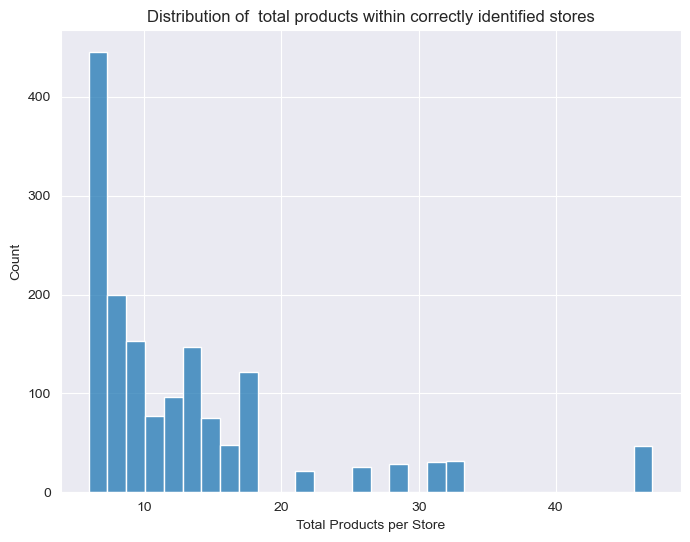

In [23]:
#Distribution of products in corectly identified stores

storenames_incorrect = set(incorrect_samples['store_grouped'])
storenames_all= set(X_train['store_grouped'])

correctly_identified_stores = list(storenames_all.difference(storenames_incorrect))
#correct_pred = (y_train == y_pred_train)

sns.histplot(data = model_df.loc[model_df['store_grouped'].isin(correctly_identified_stores)], x = 'store_grouped_total_products',bins=30)
plt.ylabel('Count')
plt.xlabel('Total Products per Store')
plt.title('Distribution of  total products within correctly identified stores')
plt.show()

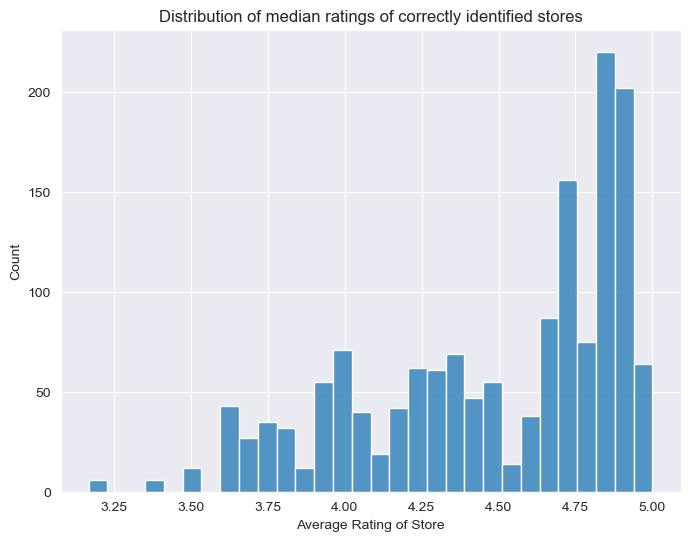

In [24]:
sns.histplot(data = model_df.loc[model_df['store_grouped'].isin(correctly_identified_stores)], x = 'store_grouped_weighted_mean_rating',bins=30)
plt.ylabel('Count')
plt.xlabel('Average Rating of Store')
plt.title('Distribution of median ratings of correctly identified stores')
plt.show()

In [25]:
#correctly identified stores by the model
model_df.loc[model_df["store_grouped"].isin(correctly_identified_stores),['store_grouped','store_grouped_total_products','store_grouped_weighted_mean_rating']]

,store_grouped,store_grouped_total_products,store_grouped_weighted_mean_rating
parent_asin,,,
B07QYK1Q1Z,ayalz,6,4.083333
B08KY33J2B,latika jewelry,6,3.766667
B07VYT6XJG,pabawa,18,4.461111
B0792Q82PW,circle and square decor,11,4.854545
B07SVFRY3T,clasp it boutique,8,3.962500
...,...,...,...
B01KKOZNZM,alan claude,8,4.900000
B07D8GMSF1,uyeno miyohsi,13,4.876923
B014N34096,the neighborgoods,7,4.700000


Lets look at the distribution of ratings within a couple of these correctly identified stores by the model

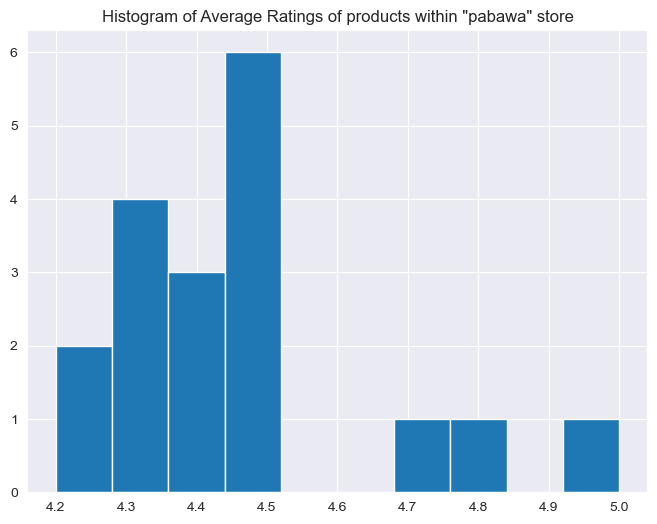

In [54]:
store_df  = model_df[model_df['store_grouped'] == 'pabawa']

store_df['average_rating'].hist()
plt.title('Histogram of Average Ratings of products within "pabawa" store')
plt.show()


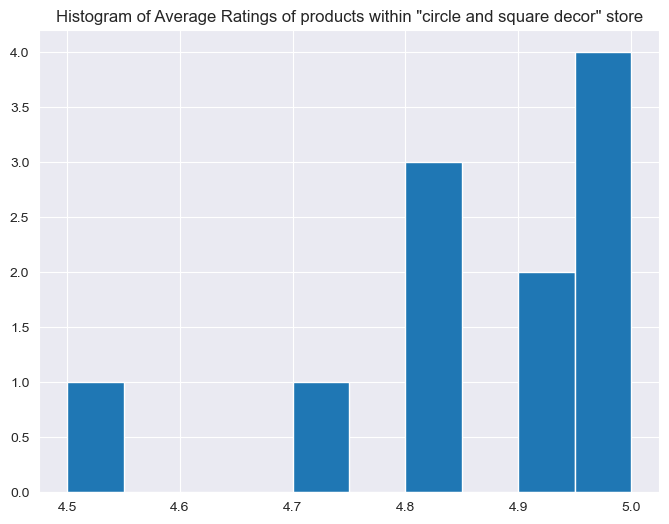

In [55]:
store_df  = model_df[model_df['store_grouped'] == 'circle and square decor']

store_df['average_rating'].hist()
plt.title('Histogram of Average Ratings of products within "circle and square decor" store')
plt.show()

**Key Insights**
- Model performs well for stores with products < 40.
- For stores with a larger number of products, the model exhibits a higher number of misclassifications.
- Model heavily relies on grouped store ratings as a proxy for all the items in the store and therefor fails to generalize to larger stores where variations may be larger.

### <a id='toc1_1_4_'></a>[Logistic Regression with Downsampling](#toc0_)

In this section, we apply a downsampling technique to address the imbalance in the target variable and assess the model’s performance.

In [76]:
#Define features
X = model_df.drop(columns=['highly_rated_product','average_rating'])

#define target
y=model_df['highly_rated_product']

#train/test split

X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, stratify = y,random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.3, stratify = y_remainder,random_state = 2)


In [77]:
# Downsample class 1 samples in the dataset
print("Number of class 1 examples before:", X_train[y_train == 1].shape[0])

# Capture indices of the original data for class 1
original_indices_class1 = X_train[y_train == 1].index

# Randomly remove positive class observations
X_remove_negative, y_remove_negative, resampled_indices = resample(
    X_train[y_train == 1],
    y_train[y_train == 1],
    X_train[y_train == 1].index,  # Capture original indices
    n_samples=X_train[y_train == 0].shape[0],
    random_state=123
)
print("Number of class 1 examples after:", X_remove_negative.shape[0])

# Capture indices of the original data for class 0
original_indices_class0 = X_train[y_train == 0].index

# Combine upsample with original data
X_train_downsampled = np.vstack((X_train[y_train == 0], X_remove_negative))
y_train_downsampled = np.hstack((y_train[y_train == 0], y_remove_negative))

# Combine original indices for class 0 and resampled indices for class 1
original_indices_combined = np.hstack((original_indices_class0, resampled_indices))

# Convert the X_train_downsampled variable numpy array into a dataframe
X_train_downsampled = pd.DataFrame(X_train_downsampled, columns=X.columns,index=original_indices_combined)

# Convert y_train_downsampled to a pandas Series and set its index to match X_train_downsampled
y_train_downsampled = pd.Series(y_train_downsampled, index=X_train_downsampled.index)

Number of class 1 examples before: 11618
Number of class 1 examples after: 9732


In [78]:
X.columns
X.isna().sum().loc[lambda x: x> 0]
#X_train.head()

Series([], dtype: int64)

In [97]:
#Fit a Logistic Regression   

tfidf_vect = TfidfVectorizer(token_pattern=r"\b[a-z]{3,}\b",  #tokens should only consider 3 or more letters 
                            lowercase=True,
                            min_df=10,                 # consider tokens that appear in atleast 5% of documents
                            max_df=0.9,                  # remove words that appear in more than 90% of documents
                            stop_words='english',        # exclude stop words
                            max_features=3000)        



#Define Column Transformer to apply Count Vectorizer to Specific columns in the dataset 
col_transforms = [
    ('features_transform', tfidf_vect, "spacy_tokenized_features"),
    ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["store_grouped","combined_category"]),
]

# Create the column transformer
preprocessor = ColumnTransformer(col_transforms,remainder='passthrough')

#Define steps for a pipeline

steps = [
("preprocessor", preprocessor),
("normalize", StandardScaler(with_mean=False)),
("logreg", LogisticRegression()),
]

#Instantiate Pipeline
pipe_logreg_downsampled = Pipeline(steps)

#Fit Pipeline
pipe_logreg_downsampled.fit(X_train_downsampled,y_train_downsampled)
avg_cv_score = np.mean(cross_val_score(pipe_logreg_downsampled, X_train_downsampled,y_train_downsampled,cv=5))


#Score
print(f' Train Accuracy: {np.round(pipe_logreg_downsampled.score(X_train_downsampled,y_train_downsampled),4)}')
print(f' Validation Accuracy: {np.round(pipe_logreg_downsampled.score(X_val,y_val),4)}')


 Train Accuracy: 0.7846
 Validation Accuracy: 0.6573


#### <a id='toc1_1_3_1_'></a>[Hyper parameter tuning](#toc0_)

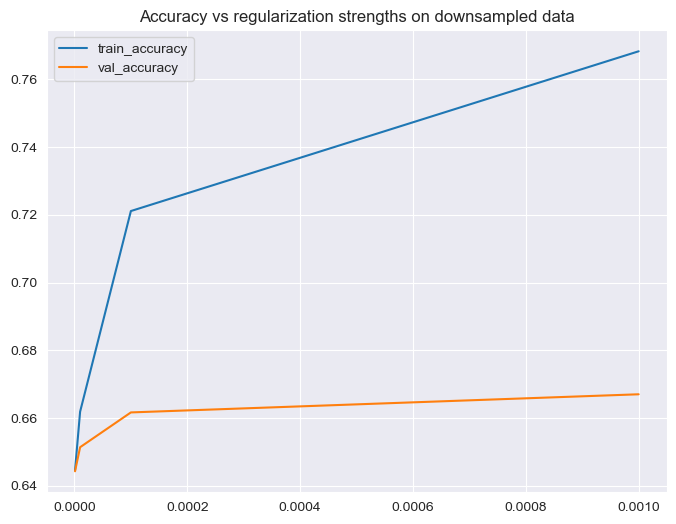

In [98]:
# Tune regularization in Logistic Regression 

train_accuracy = []
val_accuracy = []
param_range = [1e-6, 1e-5, 1e-4, 1e-3]

#Instantiate pipeline
pipe_loop = Pipeline([
    ("preprocessor", preprocessor),
    ("normalize", StandardScaler(with_mean=False)),
    ("log_reg", LogisticRegression())  # Default parameters
])


for C_param in param_range:
        
    #Update parameter hyper-parameter for every iteration
    pipe_loop.set_params(log_reg__C = C_param)    

    #Fit data
    pipe_loop.fit(X_train_downsampled, y_train_downsampled)

    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train_downsampled, y_train_downsampled))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(param_range,train_accuracy,label='train_accuracy')
plt.plot(param_range,val_accuracy,label='val_accuracy')
plt.title('Accuracy vs regularization strengths on downsampled data')
plt.legend()
plt.show()

We observe minimal overfitting with a very high regularization strength. Therefore we will refit the model with C = 1e-5.

In [ ]:
#Refitting Logreg with C=1e-5

steps = [
("preprocessor", preprocessor),
("normalize", StandardScaler(with_mean=False)),
("logreg", LogisticRegression(C=1e-5)),
]

#Instantiate Pipeline
pipe_logreg_downsampled_final = Pipeline(steps)

#Fit Pipeline
pipe_logreg_downsampled_final.fit(X_train_downsampled,y_train_downsampled)

#Score
print(f' Train Accuracy of final model: {np.round(pipe_logreg_downsampled_final.score(X_train_downsampled,y_train_downsampled),4)}')
print(f' Test Accuracy of final model: {np.round(pipe_logreg_downsampled_final.score(X_test,y_test),4)}')


 Train Accuracy of final model: 0.6619
 Test Accuracy of final model: 0.641


#### <a id='toc1_1_3_2_'></a>[Model Evaluation](#toc0_)

Confusion matrices: 



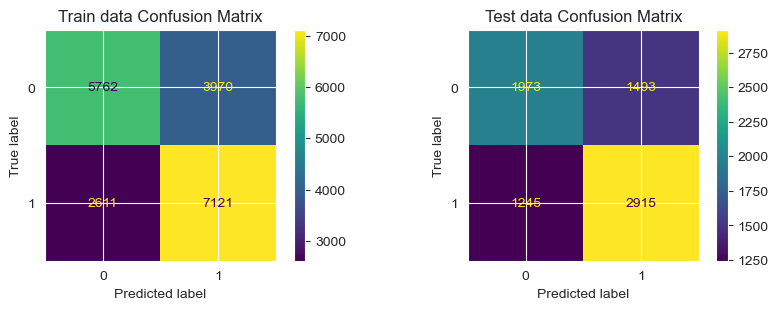


Train data classification report: 
               precision    recall  f1-score   support

           0       0.69      0.59      0.64      9732
           1       0.64      0.73      0.68      9732

    accuracy                           0.66     19464
   macro avg       0.67      0.66      0.66     19464
weighted avg       0.67      0.66      0.66     19464


Test data classification report: 
               precision    recall  f1-score   support

           0       0.61      0.57      0.59      3466
           1       0.66      0.70      0.68      4160

    accuracy                           0.64      7626
   macro avg       0.64      0.63      0.64      7626
weighted avg       0.64      0.64      0.64      7626



In [100]:
#Make predictions
y_pred_train = pipe_logreg_downsampled_final.predict(X_train_downsampled)
y_pred_test = pipe_logreg_downsampled_final.predict(X_test)

print_line = "\n=======================================================\n"
# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the downsampled data - training 
ConfusionMatrixDisplay.from_estimator(pipe_logreg_downsampled_final, X_train_downsampled, y_train_downsampled, ax=axes[0])
axes[0].set_title("Train data Confusion Matrix")

# also saving the confusion matrix
conmat_downsampled = pd.DataFrame(
    data = confusion_matrix(y_test, y_pred_test),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)

# Model on the downsampled data - test
ConfusionMatrixDisplay.from_estimator(pipe_logreg_downsampled_final, X_test, y_test, ax=axes[1])
axes[1].set_title("Test data Confusion Matrix")

plt.show()

# Classification Reports
print("\nTrain data classification report:", print_line, classification_report(y_train_downsampled,y_pred_train))
print("\nTest data classification report:", print_line, classification_report(y_test,y_pred_test))

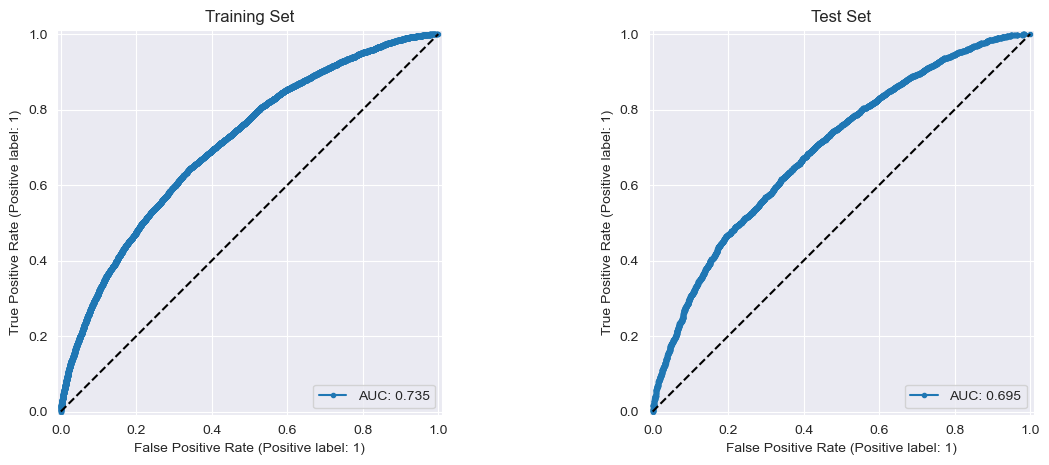

In [101]:
#Compute ROC-AUC curve for positive class

# Set up subplot structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predict probabilities
y_proba_train = pipe_logreg_downsampled_final.predict_proba(X_train_downsampled)[:, 1]
y_proba_test = pipe_logreg_downsampled_final.predict_proba(X_test)[:, 1]

# Score (AUC)
auc_train = np.round(roc_auc_score(y_train_downsampled, y_proba_train), 3)
auc_test = np.round(roc_auc_score(y_test, y_proba_test), 3)

# Labels
train_label = f"AUC: {auc_train}"
test_label = f"AUC: {auc_test}"

# Plot ROC curve

# Using RocCurveDisplay - pass in the fitted model, then the X data, then the y data
RocCurveDisplay.from_estimator(pipe_logreg_downsampled_final, X_train, y_train, ax=axes[0], marker=".", label=train_label)
RocCurveDisplay.from_estimator(pipe_logreg_downsampled_final, X_test, y_test, ax=axes[1], marker=".", label=test_label)

axes[0].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[1].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[0].set_title("Training Set")
axes[1].set_title("Test Set")

plt.show()

#### Model Comparison


In [102]:
print('Unsampled:')
display(conmat)
print('Downsampled data:')
display(conmat_downsampled)

Unsampled:


,predicted 0,predicted 1
true 0,1661,1815
true 1,943,3207


Downsampled data:


,predicted 0,predicted 1
true 0,1973,1493
true 1,1245,2915


Model Summary on Class 0 (low rated item)
| |precision|recall|F1|ROC-AUC
|-|---------|------|--|------|
|**logreg on unsampled data**|64%|48%|55%|69%
|**logreg on downsampled data**|61%|57%|59%|69.5%

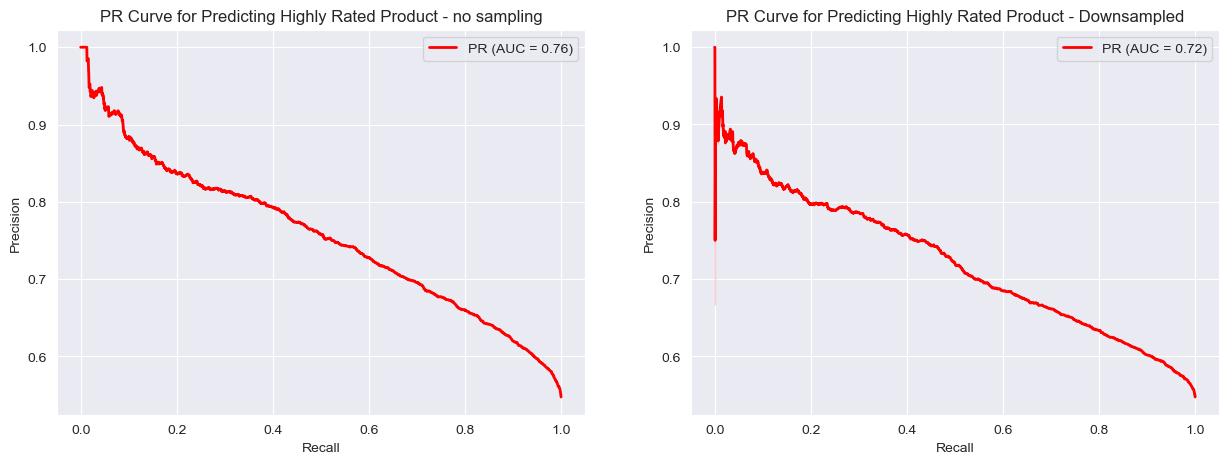

In [115]:
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)

# probabilistic prediction
y_test_proba =  pipe_logreg_final.predict_proba(X_test)[:,1] # probabilities of data points being in the positive class

# ROC arrays
precision_, recall_, thresholds_ = precision_recall_curve(y_test, y_test_proba)

# auc precision-recall
aucpr = auc(recall_, precision_)

sns.lineplot(x=recall_, y=precision_, color='red', lw=2, label=f'PR (AUC = {auc(recall_, precision_):0.2f})')
# sns.lineplot([0, 1], [0, 1], color='black', lw=2, label='random guess') # random guess
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Predicting Highly Rated Product - no sampling')
plt.legend(loc='best')

plt.subplot(1,2,2)

# probabilistic prediction
y_test_proba_downsampled = pipe_logreg_downsampled_final.predict_proba(X_test)[:,1] # probabilities of data points being in the positive class

# ROC arrays
precision_downsampled, recall_downsampled, thresholds_ = precision_recall_curve(y_test, y_test_proba_downsampled)
# auc precision-recall
aucpr_downsampled = auc(recall_downsampled, precision_downsampled)

sns.lineplot(x=recall_downsampled, y=precision_downsampled, color='red', lw=2, label=f'PR (AUC = {auc(recall_downsampled, precision_downsampled):0.2f})')
# sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, label='random guess') # random guess
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Predicting Highly Rated Product - Downsampled')
plt.legend(loc='best')

plt.show()

**Key Insights**
- Training a logistic regression model on under-sampled data moderately increases the recall and F1-score of the negative class, but precision declines.  
- The AUC-ROC score remains similar for both models, suggesting a tradeoff between the cost of false negatives and false positives.  
- PR-AUC declines after downsampling, indicating that the model's ability to distinguish positive cases from negative ones has worsened.  

### <a id='toc1_1_5_'></a>[Random Forest](#toc0_)

In this section, we fit a Random Forest model to the same dataset and asses its performance.

In [104]:
#Define features

X = model_df.drop(columns=['highly_rated_product',
                           'average_rating'])
#define target
y=model_df['highly_rated_product']
X.columns

#lets split the data into train and test before applying transformations

X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.3, stratify = y_remainder,random_state = 2)

In [116]:
#Build a random forest pipeline to systematically apply all the transformation


tfidf_vect = TfidfVectorizer(token_pattern=r"\b[a-z]{3,}\b",  #tokens should only consider 3 or more letters
                            lowercase=True,
                            min_df=10,                 # consider tokens that appear in atleast 5% of documents
                            max_df=0.9,                  # remove words that appear in more than 90% of documents
                            stop_words='english',        # exclude stop words
                            max_features = 3000)         #generate a max of 3000 tokens


#Define Column Transformer to apply TfIdf vectorizer to specific columns in the dataset 
col_transforms = [
     ("title_transform", tfidf_vect, "spacy_tokenized_features"),
    ("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["store_grouped","combined_category"]),
]

# Create the column transformer
preprocessor = ColumnTransformer(col_transforms,remainder='passthrough')

# Define Steps for Pipeline (Random Forest)
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("normalize", StandardScaler(with_mean=False)),
    ("rf", RandomForestClassifier(max_depth=8,n_estimators=100))  # Default parameters
])

#Fit Pipeline
pipe_rf.fit(X_train,y_train)
#avg_cv_score = np.mean(cross_val_score(pipe_logreg, X_train,y_train,cv=5))

#Score
print(f' Train Accuracy: {pipe_rf.score(X_train,y_train)}')
print(f' Validation Accuracy: {pipe_rf.score(X_val,y_val)}')


 Train Accuracy: 0.6678688524590164
 Validation Accuracy: 0.6428805595016938


#### <a id='toc1_1_5_1_'></a>[Hyperparameter tuning](#toc0_)

Parameter 1: Max Depth

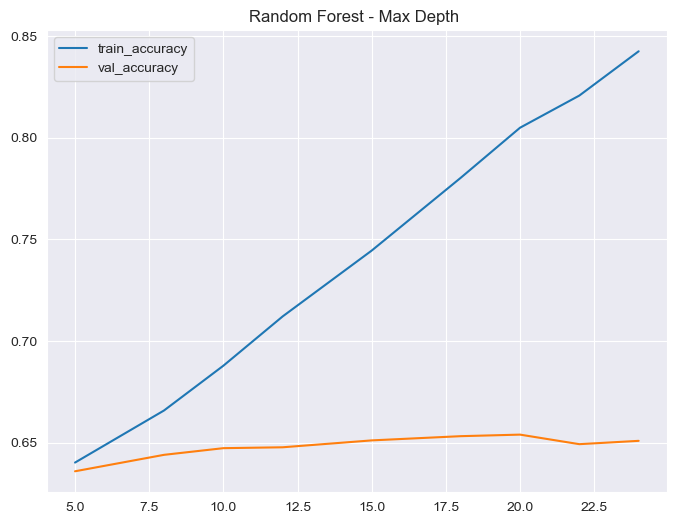

In [117]:
# Run a for loop with different max depths

train_accuracy = []
val_accuracy = []
depth_range = [5,8,10,12,15,18,20,22,24]

#Instantiate pipeline
pipe_loop = Pipeline([
    ("preprocessor", preprocessor),
    ("normalize", StandardScaler(with_mean=False)),
    ("rf", RandomForestClassifier())  # Default parameters
])


for depth in depth_range:
    #Update min_samples_leaf hyper-parameter for every iteration
    pipe_loop.set_params(rf__max_depth = depth)    
    
    #Fit data
    pipe_loop.fit(X_train, y_train)
    
    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(depth_range,train_accuracy,label='train_accuracy')
plt.plot(depth_range,val_accuracy,label='val_accuracy')
plt.title('Random Forest - Max Depth ')
plt.legend()
plt.show()

The model begins to overfit beyond max_depth = 10. We now fine-tune other parameters in our model- specifically n_estimaros and min_samples_leaf

Parameter 2: n_estimators or number of decision trees in the model

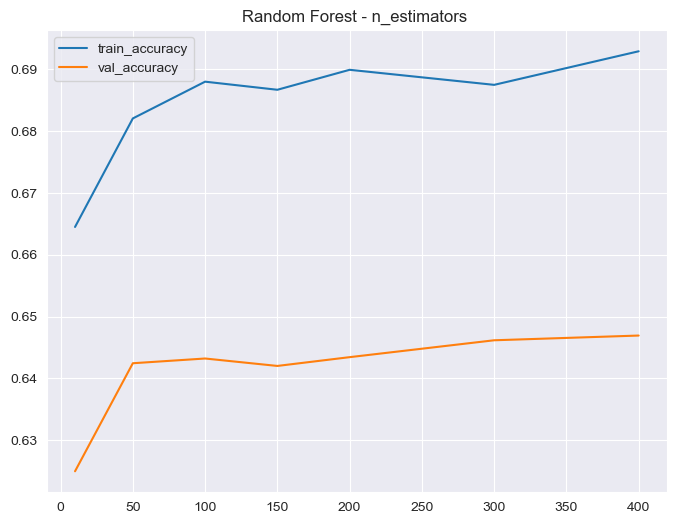

In [126]:
# Run a for loop with different n_estimators

train_accuracy = []
val_accuracy = []
param_range = [10,50,100,150,200,300,400]

#Instantiate pipeline
pipe_loop = Pipeline([
    ("preprocessor", preprocessor),
    ("normalize", StandardScaler(with_mean=False)),
    ("rf", RandomForestClassifier(max_depth=10))  # Default parameters
])

for param in param_range:
    #Update parameter hyper-parameter for every iteration
    pipe_loop.set_params(rf__n_estimators = param)    
    
    #Fit data
    pipe_loop.fit(X_train, y_train)
    
    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(param_range,train_accuracy,label='train_accuracy')
plt.plot(param_range,val_accuracy,label='val_accuracy')
plt.title('Random Forest - n_estimators ')
plt.legend()
plt.show()

As we change n_estimators, we don't see any significant differences in the accuracy. We choose n_estimators=50 for our final model.

Parameter 3: min_samples_leaf

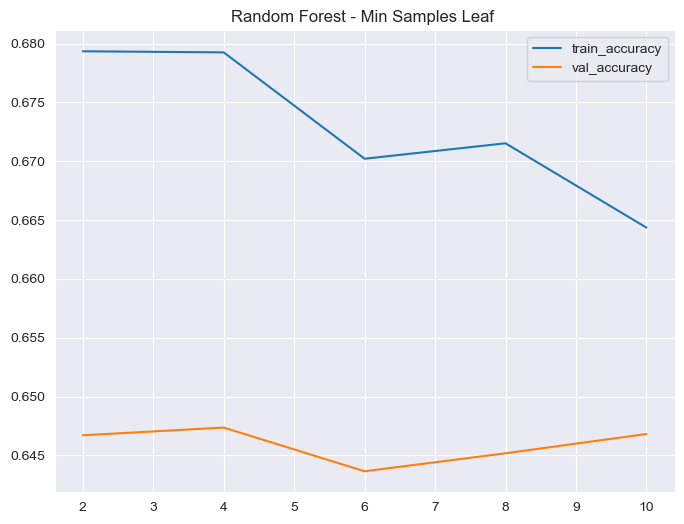

In [134]:
# Run a for loop with different min_samples_leaf

train_accuracy = []
val_accuracy = []
param_range = [2,4,6,8,10]

#Instantiate pipeline
pipe_loop = Pipeline([
    ("preprocessor", preprocessor),
    ("normalize", StandardScaler(with_mean=False)),
    ("rf", RandomForestClassifier(max_depth=10, n_estimators=50))  # Default parameters
])


for param in param_range:
    #Update min_samples_leaf hyper-parameter for every iteration
    pipe_loop.set_params(rf__min_samples_leaf = param)    
    
    #Fit data
    pipe_loop.fit(X_train, y_train)
    
    # Train on traning set
    train_accuracy.append(pipe_loop.score(X_train, y_train))

    # Score on validation set
    val_accuracy.append(pipe_loop.score(X_val, y_val))


plt.plot(param_range,train_accuracy,label='train_accuracy')
plt.plot(param_range,val_accuracy,label='val_accuracy')
plt.title('Random Forest - Min Samples Leaf ')
plt.legend()
plt.show()

Again, min_samples_leaf has a minimal impact on the model's performance, We choose min_samples_leaf = 4 in our final model.

In [135]:
#Refitting Random Forest with max_depth = 10, n_estimators = 50, min_samples_leaf = 4 on test data

steps = [
("preprocessor", preprocessor),
("normalize", StandardScaler(with_mean=False)),
("rf", RandomForestClassifier(max_depth = 10, n_estimators = 50, min_samples_leaf = 4)),
]

#Instantiate Pipeline
pipe_rf_final = Pipeline(steps)

#Fit Pipeline
pipe_rf_final.fit(X_train,y_train)
avg_cv_score = np.mean(cross_val_score(pipe_rf_final, X_train,y_train,cv=5))


#Score
print(f' Train Accuracy of final model: {np.round(pipe_rf_final.score(X_train,y_train),4)}')
print(f' Test Accuracy of final model: {np.round(pipe_rf_final.score(X_test,y_test),4)}')


 Train Accuracy of final model: 0.6753
 Test Accuracy of final model: 0.6324


#### Feature Importances

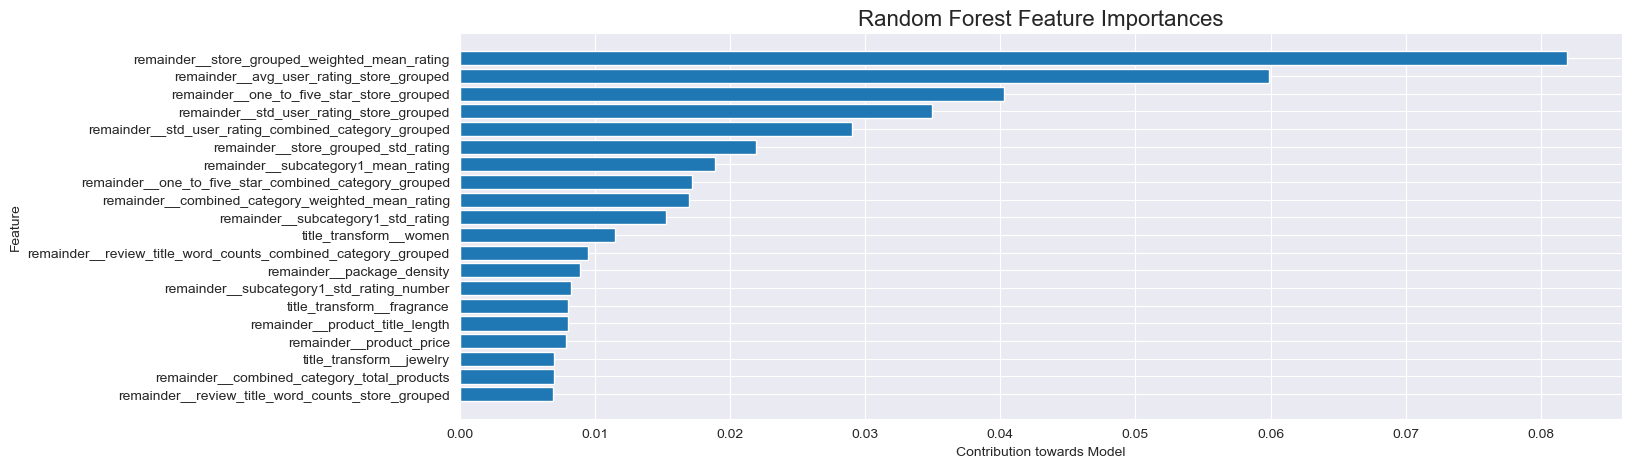

In [136]:
#Get feature names from the ColumnTransformer
feature_names = pipe_rf_final.named_steps['preprocessor'].get_feature_names_out()

#Extract coefficients from the logistic regression model
feature_importances = pipe_rf_final.named_steps['rf'].feature_importances_  

# Create the DataFrame to map feature names to coefficients
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True) # Sort coefficients in descending order

importance_df_top20 = importance_df.head(20)  
importance_df_top20 = importance_df_top20.sort_values(by = 'Importance')
# Plotting Feature Importances
plt.figure(figsize=(15,5))

plt.barh(importance_df_top20['Feature'], importance_df_top20['Importance'])

plt.title('Random Forest Feature Importances', fontsize=16)
plt.xlabel('Contribution towards Model')
plt.ylabel('Feature')
sns.despine()
plt.show()

Similar to Logistic Regression, Random Forest Model also identifies numerical features in the model as more important than the categorical features

### Model Evaluation

Confusion matrices: 



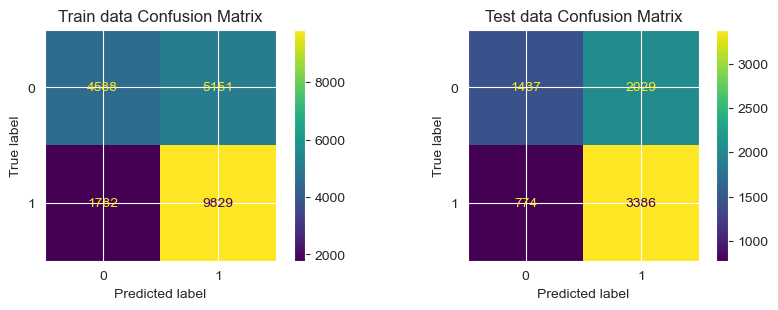


Train data classification report: 
               precision    recall  f1-score   support

           0       0.72      0.47      0.57      9739
           1       0.66      0.85      0.74     11611

    accuracy                           0.68     21350
   macro avg       0.69      0.66      0.65     21350
weighted avg       0.69      0.68      0.66     21350


Test data classification report: 
               precision    recall  f1-score   support

           0       0.65      0.41      0.51      3466
           1       0.63      0.81      0.71      4160

    accuracy                           0.63      7626
   macro avg       0.64      0.61      0.61      7626
weighted avg       0.64      0.63      0.62      7626



In [137]:
#Make predictions
y_pred_train = pipe_rf_final.predict(X_train)
y_pred_test = pipe_rf_final.predict(X_test)

print_line = "\n=======================================================\n"
# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
ConfusionMatrixDisplay.from_estimator(pipe_rf_final, X_train, y_train, ax=axes[0])
axes[0].set_title("Train data Confusion Matrix")

# Model on the upsampled data
ConfusionMatrixDisplay.from_estimator(pipe_rf_final, X_test, y_test, ax=axes[1])
axes[1].set_title("Test data Confusion Matrix")

plt.show()

# also saving the confusion matrix
conmat_rf = pd.DataFrame(
    data = confusion_matrix(y_test, y_pred_test),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)

# Classification Reports
print("\nTrain data classification report:", print_line, classification_report(y_train,y_pred_train))
print("\nTest data classification report:", print_line, classification_report(y_test,y_pred_test))

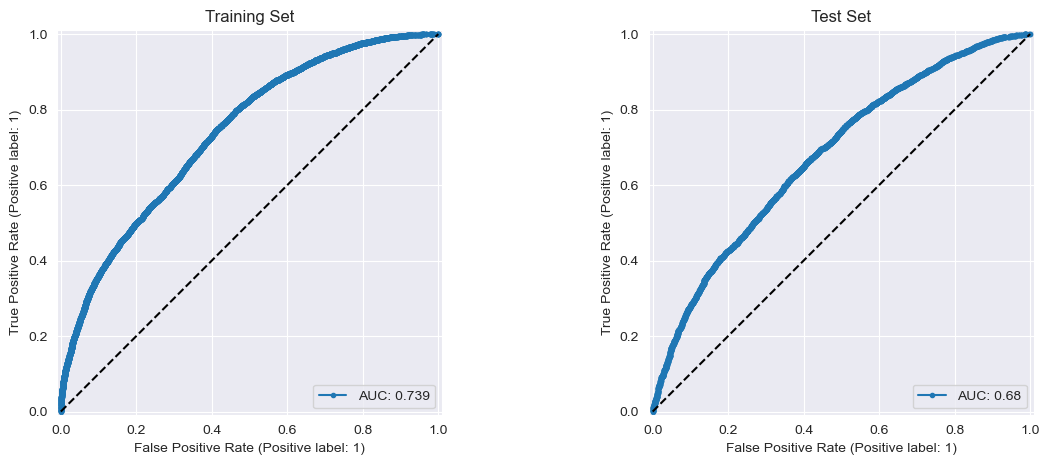

In [141]:
#Compute ROC-AUC curve for positive class

# Set up subplot structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predict probabilities
y_proba_train = pipe_rf_final.predict_proba(X_train)[:, 1]
y_proba_test = pipe_rf_final.predict_proba(X_test)[:, 1]

# Score (AUC)
auc_train = np.round(roc_auc_score(y_train, y_proba_train), 3)
auc_test = np.round(roc_auc_score(y_test, y_proba_test), 3)

# Labels
train_label = f"AUC: {auc_train}"
test_label = f"AUC: {auc_test}"

# Plot ROC curve

# Using RocCurveDisplay - pass in the fitted model, then the X data, then the y data
RocCurveDisplay.from_estimator(pipe_rf_final, X_train, y_train, ax=axes[0], marker=".", label=train_label)
RocCurveDisplay.from_estimator(pipe_rf_final, X_test, y_test, ax=axes[1], marker=".", label=test_label)

axes[0].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[1].plot([0, 1], [0, 1], color="black", linestyle="--")
axes[0].set_title("Training Set")
axes[1].set_title("Test Set")

plt.show()

### Comparison to logistic Regression

In [138]:
print('Logistic Regression:')
display(conmat)
print('Random Forest:')
display(conmat_rf)

Logistic Regression:


,predicted 0,predicted 1
true 0,1661,1815
true 1,943,3207


Random Forest:


,predicted 0,predicted 1
true 0,1437,2029
true 1,774,3386


Model Summary on Class 0 (low rated item)
| |precision|recall|F1|ROC-AUC
|-|---------|------|--|------|
|**logreg on unsampled data**|64%|48%|55%|69%
|**random forest on unsampled data**|65%|41%|51%|68%

Logistic Regression achieved much higher recall compared to Random Forest, indicating it identified more low-rated items correctly. Both, Random Forest and Logistic have similar precision, meaning both of them have made similar false positive predictions. Additionally, both models performed similarly in terms of ROC-AUC, suggesting comparable overall classification ability.

### Conclusion

Both Logistic Regression and Random Forest underfit the dataset, achieving a similar accuracy of 65% on the test data. Addressing class imbalance through downsampling does not improve the model’s ROC-AUC score, indicating that it struggles to distinguish between highly rated and lower-rated products.

The model heavily relies on a few key features, such as the average store rating and the number of low-rated items per store, making it inefficient at capturing variations in product ratings across different stores. Additionally, textual metadata, such as product features, does not exhibit strong predictive power in determining product popularity.

While the model identifies a few key product features as important, it fails to capture meaningful trends from simple vectorization of the tokens. To improve performance, the model would benefit from more meaningful and diverse features. We could

-  improve the tokenization of product features further to see if it enhances overall performance.
- explore unsupervised approaches to capture the non-linear trends in the dataset better
- employ neural networks as that may help capture more complex patterns in the data.

### <a id='toc1_1_7_'></a>[Naive Bayes Classifier](#toc0_)

While we had also explored the Naïve Bayes classifier, we did not see significant improvements in different accuracy metrics compared to logistic regression and random forest. Therefore, we decided not to include this section as part of the final workflow.

In [139]:

# #Define features
# X = model_df.drop(columns=['highly_rated_product','store_grouped','review_title_store_grouped','review_text_store_grouped','sub_category_2','rating_number'])

# #define target
# y=model_df['highly_rated_product']


# #lets split the data into train and test before applying transformations

# X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

# X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.3,random_state = 2)

In [140]:
# #Build a pipeline to systematically apply all the transformation
# from xgboost import XGBClassifier
# from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso

# tfidf_vect_title = TfidfVectorizer(token_pattern = r"\b[a-z]{3,}\b", #tokens should only consider 3 or more letters
#                                    #ngram_range=(1,2),
#                                    lowercase=True,
#                                    min_df=0.005,             # consider tokens that appear in atleast 20 documents
#                                    max_df=0.9,             # remove words that appear in more than 90% of documents
#                                    stop_words='english', #exclude stop words
#                                    max_features = 6000)       #generate a max of 500 tokens


# #Define Column Transformer to apply Count Vectorizer to Specific columns in the dataset 
# col_transforms = [
#     #('features_transform', tfidf_vect_title, "features"),
#      ("features_transform", tfidf_vect_title, "spacy_tokenized_features"),
#     #("desc_transform", tfidf_vect_desc, "description_product"),
#     #("ohe", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["store_grouped"]),
# ]

# # Create the column transformer
# preprocessor = ColumnTransformer(col_transforms,remainder='passthrough')


# # Function to convert sparse to dense and ensure NumPy array
# def sparse_to_dense(x):
#     """Convert sparse matrix to dense numpy array if it's sparse"""
#     if hasattr(x, "toarray"):  # Check if it's a sparse matrix
#         return x.toarray()
#     return np.array(x)  # Convert everything else to a NumPy array

# #Create Function Transformer using sparse_to_dense from preprocessing
# to_dense_transformer = FunctionTransformer(sparse_to_dense)

# # Define Steps for Pipeline 
# pipe_rf = Pipeline([
#     ("preprocessor", preprocessor),
#     ("to_dense", to_dense_transformer),
#     ("normalize", StandardScaler()),
#     #("linear_reg", Ridge())
#     ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
#     #("nb", MultinomialNB())  # Default parameters
# ])

# #Fit Pipeline
# pipe_rf.fit(X_train,y_train)

# #Score
# print(f' Train Accuracy: {pipe_rf.score(X_train,y_train)}')
# print(f' Validation Accuracy: {pipe_rf.score(X_val,y_val)}')
